# Amazon Open Source Analysis

This project analyzes Amazon's Free and Open Source Software (FOSS) Contributions to
determine the extent to which they behave as good citizens of the open source community.
Much has been said about Amazon and open source software, much of it good from Amazon and
much of it bad from the community. But what is the reality? Numbers that tend to indicate
good citizenship are cited by Amazon, Google, Microsoft and other cloud providers but they
are never checked for accuracy, honesty and integrity. This project aims to change that by
rigorously evaluating the open source contributions of cloud providers, starting with Amazon.

This project is an attempt to check the veracity of the claim made by Deirdré Straughan, managing editor of the AWS Open Source blog, on April 8, 2019 that, "Amazon has contributed [over 1,800 projects](https://github.com/search?utf8=%E2%9C%93&q=+user%3Aalexa+user%3Aamzn+user%3Aaws+user%3Aawsdocs+user%3Aawslabs+user%3Aaws-quickstart+user%3Ablox+user%3Aboto+user%3Ac9+user%3Acorretto+user%3Afirecracker-microvm+user%3Aaws-robotics+user%3Aajaxorg+user%3Agluon-api+user%3Acloud9ide+user%3ACarbonado+user%3Agoodreads+user%3AIvonaSoftware+user%3Atwitchtv+user%3Atwitchdev+user%3Atwitchscience+user%3Ajustintv+user%3AZappos+user%3Aamazon-archives+user%3Aalexa-labs+user%3Aaws-samples+user%3Aaws-amplify+user%3Aaws-cloudformation+user%3Aaws-solutions+user%3Aopendistro-for-elasticsearch+user%3Aopendistro&type=Repositories&ref=advsearch&l=&l=)
across 30 GitHub organizations ranging from [Alexa](https://github.com/alexa) to
[Zappos](https://github.com/Zappos). You can search them all from
[aws.github.com](https://aws.github.io/)."

## Source: Snorkel Tutorials

This project uses code from the [Snorkel Tutorials](https://github.com/snorkel-team/snorkel-tutorials) at [https://github.com/snorkel-team/snorkel-tutorials](https://github.com/snorkel-team/snorkel-tutorials)

Thanks to the [Snorkel Team](https://www.snorkel.org/) for making this important work feasible.

In [101]:
# Make sure randomness is reproducible
import random
random.seed('31337')

import warnings
warnings.simplefilter("ignore")

In [26]:
import pandas as pd

# Load the AWS Github repo READMEs scraped from Github
df = pd.read_json('data/aws_repos.jsonl', lines=True)
print(f'Total repositories: {len(df.index):,}')
df.head(3)

Total repositories: 2,469


,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,mirror_url,archived,disabled,open_issues_count,license,forks,open_issues,watchers,default_branch,score
0,61861755,MDEwOlJlcG9zaXRvcnk2MTg2MTc1NQ==,alexa-skills-kit-sdk-for-nodejs,alexa/alexa-skills-kit-sdk-for-nodejs,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-skills-kit-sdk-...,The Alexa Skills Kit SDK for Node.js helps you...,False,https://api.github.com/repos/alexa/alexa-skill...,...,NaN,False,False,10,"{'key': 'apache-2.0', 'name': 'Apache License ...",662,10,2774,2.0.x,1
1,84138837,MDEwOlJlcG9zaXRvcnk4NDEzODgzNw==,alexa-cookbook,alexa/alexa-cookbook,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-cookbook,A series of sample code projects to be used fo...,False,https://api.github.com/repos/alexa/alexa-cookbook,...,NaN,False,False,15,"{'key': 'apache-2.0', 'name': 'Apache License ...",899,15,1534,master,1
2,63275452,MDEwOlJlcG9zaXRvcnk2MzI3NTQ1Mg==,skill-sample-nodejs-fact,alexa/skill-sample-nodejs-fact,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,False,https://api.github.com/repos/alexa/skill-sampl...,...,NaN,False,False,4,"{'key': 'apache-2.0', 'name': 'Apache License ...",1174,4,989,master,1


## Get READMEs for each repository

The [Github README API](https://developer.github.com/v3/repos/contents/#get-the-readme) makes it very easy to download the README of a project. Let's fetch the README of every Amazon open source project on Github.

**Note: you need only run the following four code cells once, thereafter skip ahead to the 4th cell.**

In [6]:
# import base64
# import os
# import time

# import github


# GITHUB_PERSONAL_TOKEN = os.environ.get('GITHUB_PERSONAL_TOKEN')
# if not GITHUB_PERSONAL_TOKEN:
#     raise Exception('GITHUB_PERSONAL_TOKEN undefined!')

# g = github.Github(GITHUB_PERSONAL_TOKEN)

In [7]:
# def get_readme(full_name):
#     """Get the repo for full_name, get the readme, then decode base64->bytes->utf8"""
#     repo = g.get_repo(full_name)
#     readme_bin = repo.get_readme().content
#     readme = base64.b64decode(readme_bin).decode()
#     return readme

# # Given a project full_name (owner/repo), fetch the README and return as a UTF-8 string
# readmes = []
# for i, full_name in df['full_name'].iteritems():
#     try:
#         readme = get_readme(full_name)
#         readmes.append(readme)
#     except github.UnknownObjectException as e:
#         print(e)
#         readmes.append('')
#     except github.RateLimitExceededException as e:
#         print(e)
        
#         # Sleep for an hour + a 2 minute safety margin, if we hit the 5,000/hr rate limit
#         time.sleep(60 * 62)
        
#         # Get the repo again, now that we aren't rate limited
#         readme = get_readme(full_name)
#         readmes.append(readme)

In [27]:
# df['readme'] = pd.Series(readmes)
# df.head(3)

## Store the Data for Hand Labeling of a Sample

Store the data as CSV for hand labeling to guide our Labeling Function development. Also store to Parquet.

In [5]:
# import pyarrow


# # Save to CSV for hand labeling
# df[[
#     'id', 'full_name', 'description', 'fork', 'forks_count', 'language', 'homepage',
#     'open_issues_count', 'watchers', 'readme', 
# ]].to_csv(
#     'data/aws_readmes.csv',
#     index_label='index',
# )

# # Save relevant features to Parquet for safe keeping
# df[['id', 'full_name', 'description', 'fork', 'forks_count', 'language', 'homepage',
#     'open_issues_count', 'watchers', 'readme',
# ]].to_parquet(
#     'data/aws_readmes.parquet',
#     engine='pyarrow'
# )

## Load the READMEs

We now load the READMEs back and join it with the original repository DataFrame.

**Note: From now on we will simply load the data, skipping the previous cell.**

In [28]:
# Temporary load from other machine
import pyarrow

readme_df = pd.read_parquet('data/aws_readmes.parquet', engine='pyarrow')[['id', 'readme']]

# Join READMEs in and drop duplicate ID column
df_join = df.join(readme_df, lsuffix='_readme_df')
del df_join['id_readme_df']

df = df_join

df.head(3)

,node_id,name,full_name,private,owner,html_url,description,fork,url,forks_url,...,disabled,open_issues_count,license,forks,open_issues,watchers,default_branch,score,id,readme
0,MDEwOlJlcG9zaXRvcnk2MTg2MTc1NQ==,alexa-skills-kit-sdk-for-nodejs,alexa/alexa-skills-kit-sdk-for-nodejs,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-skills-kit-sdk-...,The Alexa Skills Kit SDK for Node.js helps you...,False,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,...,False,10,"{'key': 'apache-2.0', 'name': 'Apache License ...",662,10,2774,2.0.x,1,61861755,"<p align=""center"">\n <img src=""https://m.medi..."
1,MDEwOlJlcG9zaXRvcnk4NDEzODgzNw==,alexa-cookbook,alexa/alexa-cookbook,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-cookbook,A series of sample code projects to be used fo...,False,https://api.github.com/repos/alexa/alexa-cookbook,https://api.github.com/repos/alexa/alexa-cookb...,...,False,15,"{'key': 'apache-2.0', 'name': 'Apache License ...",899,15,1534,master,1,84138837,\n# Alexa Skill Building Cookbook\n\n<div styl...
2,MDEwOlJlcG9zaXRvcnk2MzI3NTQ1Mg==,skill-sample-nodejs-fact,alexa/skill-sample-nodejs-fact,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,False,https://api.github.com/repos/alexa/skill-sampl...,https://api.github.com/repos/alexa/skill-sampl...,...,False,4,"{'key': 'apache-2.0', 'name': 'Apache License ...",1174,4,989,master,1,63275452,"# Build An Alexa Fact Skill\n<img src=""https:/..."


## Create spaCy Documents from READMEs

Setup the large english language model and have it merge multi-token named entities.

In [29]:
import spacy
from spacy.pipeline import merge_entities


# Enable a GPU if you have one
spacy.prefer_gpu()

# Download the spaCy english model
spacy.cli.download('en_core_web_lg')
nlp = spacy.load("en_core_web_lg")

# Merge multi-token entities together
nlp.add_pipe(merge_entities)

nlp.pipeline


    Linking successful
    /home/rjurney/anaconda3/envs/amazon/lib/python3.7/site-packages/en_core_web_lg
    -->
    /home/rjurney/anaconda3/envs/amazon/lib/python3.7/site-packages/spacy/data/en_core_web_lg

    You can now load the model via spacy.load('en_core_web_lg')



[('tagger', <spacy.pipeline.Tagger at 0x7f9ff168a5d0>),
 ('parser', <spacy.pipeline.DependencyParser at 0x7f9fa825d110>),
 ('ner', <spacy.pipeline.EntityRecognizer at 0x7f9fa825d6b0>),
 ('merge_entities', <function spacy.pipeline.merge_entities>)]

In [31]:
df['spacy'] = df['readme'].apply(nlp)
df.head(3)

,node_id,name,full_name,private,owner,html_url,description,fork,url,forks_url,...,open_issues_count,license,forks,open_issues,watchers,default_branch,score,id,readme,spacy
0,MDEwOlJlcG9zaXRvcnk2MTg2MTc1NQ==,alexa-skills-kit-sdk-for-nodejs,alexa/alexa-skills-kit-sdk-for-nodejs,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-skills-kit-sdk-...,The Alexa Skills Kit SDK for Node.js helps you...,False,https://api.github.com/repos/alexa/alexa-skill...,https://api.github.com/repos/alexa/alexa-skill...,...,10,"{'key': 'apache-2.0', 'name': 'Apache License ...",662,10,2774,2.0.x,1,61861755,"<p align=""center"">\n <img src=""https://m.medi...","(<, p, align=""center, "", >, \n , <, img, src=..."
1,MDEwOlJlcG9zaXRvcnk4NDEzODgzNw==,alexa-cookbook,alexa/alexa-cookbook,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/alexa-cookbook,A series of sample code projects to be used fo...,False,https://api.github.com/repos/alexa/alexa-cookbook,https://api.github.com/repos/alexa/alexa-cookb...,...,15,"{'key': 'apache-2.0', 'name': 'Apache License ...",899,15,1534,master,1,84138837,\n# Alexa Skill Building Cookbook\n\n<div styl...,"(\n, #, Alexa, Skill, Building, Cookbook, \n\n..."
2,MDEwOlJlcG9zaXRvcnk2MzI3NTQ1Mg==,skill-sample-nodejs-fact,alexa/skill-sample-nodejs-fact,False,"{'login': 'alexa', 'id': 17815977, 'node_id': ...",https://github.com/alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,False,https://api.github.com/repos/alexa/skill-sampl...,https://api.github.com/repos/alexa/skill-sampl...,...,4,"{'key': 'apache-2.0', 'name': 'Apache License ...",1174,4,989,master,1,63275452,"# Build An Alexa Fact Skill\n<img src=""https:/...","(#, Build, An, Alexa, Fact, Skill, \n, <, img,..."


## Load the Gold Labeled Data

Data was labeled via a [Google Sheet](https://docs.google.com/spreadsheets/d/1ULt0KxIdb5HUJCEMt_AmOuPbTvN1zg8UA_4RvjlVwXQ/edit?usp=sharing) and exported to CSV at [data/Amazon_Open_Source_Analysis_Gold.csv](data/Amazon_Open_Source_Analysis_Gold.csv).

### Submitting Corrections or Additions

If you feel any labels are wrong, first read the definitions in the README and comment on the sheet. You may also copy the Google Sheet and continue labeling yourself if you want to ensure the accuracy of this analysis.

In [32]:
# Load all 2,469 records and then filter out the unlabeled ones
df_gold = pd.read_csv('data/Amazon_Open_Source_Analysis_Gold.csv')

df_gold = df_gold[df_gold['label'].notnull()]
print(f'Gold labeled records: {len(df_gold.index):,}')

df_gold = df.set_index('id').join(
    df_gold.set_index('id'),
    how='inner',
    on='id',
    rsuffix='_gold',
)

# Drop duplicate columns
df_gold = df_gold.drop(
    [
        'full_name_gold','url_gold','description_gold','fork_gold','forks_count_gold',
        'language_gold','homepage_gold','open_issues_count_gold','watchers_gold', 
        'readme_gold',
        
    ],
    axis=1,
)

# Drop ABSTAIN labels
df_gold = df_gold[df_gold['label'] != 'ABSTAIN']
print(f'Records minus ABSTAIN: {len(df_gold.index):,}')

df_gold[['full_name', 'label']].head(20)

Gold labeled records: 203
Records minus ABSTAIN: 202


,full_name,label
id,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,API
84138837,alexa/alexa-cookbook,EDUCATION
63275452,alexa/skill-sample-nodejs-fact,EDUCATION
81483877,alexa/avs-device-sdk,API
38904647,alexa/alexa-skills-kit-sdk-for-java,API
130283857,alexa/alexa-skills-kit-sdk-for-python,API
61861729,alexa/skill-sample-nodejs-adventure-game,EDUCATION
66025531,alexa/skill-sample-nodejs-audio-player,EDUCATION
88652049,alexa/alexa-smarthome,API


### Defining Label Schema

The labels for this dataset are:

| Number | Code      | Description                      |
|--------|-----------|----------------------------------|
| -1     | ABSTAIN   | No vote, for Labeling Functions  |
| 0      | GENERAL   | A FOSS project of general appeal |
| 1      | API       | An API library for AWS           |
| 2      | EDUCATION | An educational library for AWS   |
| 3      | DATASET   | An open dataset by Amazon        |

In [157]:
ABSTAIN   = -1
GENERAL   = 0
API       = 1
EDUCATION = 2
DATASET   = 3

names  = ['GENERAL', 'API', 'EDUCATION', 'DATASET']

In [34]:
# Map the labels to their numeric label numbers
def label_to_number(x):
    """Convert string labels from the Google Sheet to their numeric values"""
    if x == 'ABSTAIN':
        return ABSTAIN
    if x == 'GENERAL':
        return GENERAL
    if x == 'API':
        return API
    if x == 'EDUCATION':
        return EDUCATION
    if x == 'DATASET':
        return DATASET


def number_to_label(x):
    """Convert numeric labels to their values in the Google Sheet"""
    if x == ABSTAIN:
        return 'ABSTAIN'
    if x == GENERAL:
        return 'GENERAL'
    if x == API:
        return 'API'
    if x == EDUCATION:
        return 'EDUCATION'
    if x == DATASET:
        return 'DATASET'


df_gold['label_num'] = df_gold['label'].apply(label_to_number)
df_gold[['full_name','label','label_num']].head(20)

,full_name,label,label_num
id,,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,API,1
84138837,alexa/alexa-cookbook,EDUCATION,2
63275452,alexa/skill-sample-nodejs-fact,EDUCATION,2
81483877,alexa/avs-device-sdk,API,1
38904647,alexa/alexa-skills-kit-sdk-for-java,API,1
130283857,alexa/alexa-skills-kit-sdk-for-python,API,1
61861729,alexa/skill-sample-nodejs-adventure-game,EDUCATION,2
66025531,alexa/skill-sample-nodejs-audio-player,EDUCATION,2
88652049,alexa/alexa-smarthome,API,1


## Now Create a Random Forest Model using a Sparse Representation to Pick Keyword Label Functions

We will use the spaCy doc we created to lemmatize as we tokenize the words, giving us better representations for feature importances.

In [35]:
from spacy.lang.en.stop_words import STOP_WORDS


STOP_WORDS = STOP_WORDS.union(set(['-', '=', "'", '/', '.', ';', '#', '##', '###', '<', '>', ':', '\n', '\n\n', '!', '[', ']']))


def tokenize(doc):
    """Tokenize: skip stop words, return proper nouns as n-grams and lemmas for everything else"""
    tokens = []
    for token in doc:
        # Drop stop words
        if token.text.lower() in STOP_WORDS:
            continue
            
        # Lemmatize anything that isn't a proper noun
        if token.pos_ != 'PROPN':
            tokens.append(token.lemma_.lower())
        else:
            tokens.append(token.text.lower())
    return tokens


df_gold['lemmas'] = df_gold['spacy'].apply(tokenize)
df_gold['lemmas']

id
61861755     [p, align="center, ", \n  , img, src="https://...
84138837     [alexa, skill, building, cookbook, \n\n, style...
63275452     [build, alexa, fact, skill, img, src="https://...
81483877     [the alexa voice service, (, avs, ), ?, the al...
38904647     [p, align="center, ", \n  , img, src="https://...
                                   ...                        
105808767    [aws, cloud, development, kit, (, aws, cdk, ),...
574877       [aws, java, build, status](https://travis, ci....
2050163      [aws, ruby, gitter](https://badges.gitter.im, ...
107600830    [aws, lambda, godoc][1]][2, build, status][5]]...
159005377    [container, roadmap, public, roadmap, aws, con...
Name: lemmas, Length: 202, dtype: object

## TF-IDF Vectorize and Split the Text Data and Labels into Train/Test Sets

We need to vectorize the data in a sparse representation to train the model and get feature importances for each word, so we use sklearn's `TfidfVectorizer` to give more important words more weight.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


vectorizer = TfidfVectorizer(
    analyzer='word',
    min_df=3,
    stop_words=None,
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    token_pattern=None,
    lowercase=False,
    ngram_range=(1, 3)
)

df_gold_train, df_gold_test, train_labels, test_labels = train_test_split(
    df_gold,
    df_gold['label_num'],
    test_size=0.3,
    random_state=1337,
)

train_vec = vectorizer.fit_transform(
    df_gold_train['lemmas']
)
test_vec = vectorizer.transform(
    df_gold_test['lemmas']
)

## Now Train a `RandomForestClassifier` and Determine Overall Feature Importances

A random forest model can give us overall feature importances directly, but it doesn't tell us which class they were important for or in which direction: for or against.

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


# Fit the model on the training data
clf = RandomForestClassifier()
clf.fit(train_vec, train_labels)

# Score the model to see if it is worth using for inference
avg = 'weighted'
pred = clf.predict(test_vec)
print(f"Model weighted F1 score: {f1_score(test_labels, pred, average=avg)}")

# Display features and importances in a DataFrame
features = pd.DataFrame(
    {'importance': clf.feature_importances_},
    index=vectorizer.get_feature_names(),
)
features = features.sort_values(
    by=['importance'],
    ascending=False,
)
features[0:20]

Model weighted F1 score: 0.7989472200537773


/home/rjurney/anaconda3/envs/amazon/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/rjurney/anaconda3/envs/amazon/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,importance
overview build skill,0.046192
kit,0.023723
amazon,0.022725
designing,0.020133
alexa skill,0.019894
user,0.019050
& guides,0.017702
alexa,0.016257
key,0.015595
skills kit,0.014810


## Split the Data to Enable and Experiment

We need test, train and development sets to work with.

In [38]:
import numpy as np
from sklearn.model_selection import train_test_split

# Use the common notation for df_train and df_test
df_train = df
y_train = np.zeros(
    len(df.index)
)
df_test = df_gold
y_test  = df_gold['label_num'].to_numpy()

## Create Utilities for Generating Keyword `LabelFunctions`

Given a set of keywords and a set of fields, we want to generate a set of those keywords operating on each of the fields. We want the list of keywords to be together and the list of fields to be separate `LabelFunctions`, although we may or may not actually group keywords in a single LF.

In [39]:
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, field, label):
    """Given a list of tuples, look for any of a list of keywords"""
    if field in x and x[field] and any(word in x[field].lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, field, label=ABSTAIN, separate=False):
    """Given a list of keywords and a label, return a keyword search LabelingFunction"""
    prefix = 'separate_' if separate else ''
    name = f'{prefix}keyword_{keywords[0]}_field_{field}'        
    return LabelingFunction(
        name=name,
        f=keyword_lookup,
        resources=dict(
            keywords=keywords,
            field=field,
            label=label,
        ),
    )

def make_keyword_lfs(keywords, fields, label=ABSTAIN, separate=False):
    """Given a list of keywords and fields, make one or more LabelingFunctions for the keywords with each field"""
    lfs = []
    for field in fields:
        
        # Optionally make one LF per keyword
        if separate:
            for i, keyword in enumerate(keywords):
                lfs.append(
                    make_keyword_lf(
                        [keyword],
                        field,
                        label=label,
                        separate=separate,
                    )
                )
        # Optionally group keywords in a single LF for each field
        else:
            lfs.append(
                make_keyword_lf(
                    keywords,
                    field,
                    label=label,
                )
            )
    return lfs

In [40]:
%%html
<style>
table {float:left}
</style>

## Label Schema

The labels for this dataset are:

| Number | Code      | Description                      |
|--------|-----------|----------------------------------|
| -1     | ABSTAIN   | No vote, for Labeling Functions  |
| 0      | GENERAL   | A FOSS project of general appeal |
| 1      | API       | An API library for AWS           |
| 2      | EDUCATION | An educational library for AWS   |
| 3      | DATASET   | An open dataset by Amazon        |

In [41]:
%%html
<style>
table {float:left}
</style>

## Labeling Functions

Labeling functions each weakly label the data and need only be better than random. Snorkel's
unsupervised generative graphical model combines these weak labels into strong labels by 
looking at the overlap, conflict and coverage of each weak label set.

| Logic                           | Fields                               | Label       | 200 Sample Accuracy |
|---------------------------------|--------------------------------------|-------------|---------------------|
| If 'sdk' is in                  | `full_name`, `description`, `readme` | `API`       |                     |
| If 'sample' is in               | `full_name`, `description`, `readme` | `EDUCATION` |                     |
| If 'dataset' is in              | `full_name`, `description`, `readme` | `DATASET`   |                     |
| If 'demonstrate' / 'demo' is in | `full_name`, `description`, `readme` | `EDUCATION` |                     |
| If 'walkthrough' is in          | `full_name`, `description`, `readme` | `EDUCATION` |                     |
| If 'skill' is in                | `full_name`, `description`           | `EDUCATION` |                     |
| If 'kit' is in                  | `full_name`, `description`           | `EDUCATION` |                     |
| If 'toolbox' is in              | `description`                        | `GENERAL`   |                     |
| if 'extension' is in            | `description`                        | `API`       |                     |
| id 'add amazon' is in           | `description`                        | `API`       |                     |
| if 'integrate' is in            | `description`                        | `API`       |                     |
| if 'ion' is in                  | `full_name`, `description`           | `GENERAL`   |                     |
|                                 |                                      |             |                     |
|                                 |                                      |             |                     |


In [42]:
# If it says SDK, it is probably an API library
sdk_lfs = make_keyword_lfs(
    keywords=['sdk'],
    fields=['full_name', 'description'],
    label=API,
)

# Sample tends to indicate EDUCATION
sample_lfs = make_keyword_lfs(
    keywords=['sample'],
    fields=['full_name', 'description', 'readme'],
    label=EDUCATION,
)

# Datasets tend to self describe themselves :)
dataset_lfs = make_keyword_lfs(
    keywords=['dataset'],
    fields=['full_name', 'description'],
    label=DATASET,
)

# Demos be EDUCATION
demo_lfs = make_keyword_lfs(
    keywords=['demonstrate', 'demo'],
    fields=['full_name', 'description', 'readme'],
    label=EDUCATION,
)

# Walkthroughs be EDUCATION
walkthrough_lfs = make_keyword_lfs(
    keywords=['walkthrough'],
    fields=['full_name', 'description', 'readme'],
    label=EDUCATION,
)

# Anything mentioning a skill is usually an Alexa skill example, of which there are many
skill_lfs = make_keyword_lfs(
    keywords=['skill', 'skills'],
    fields=['full_name', 'description', 'readme'],
    label=EDUCATION,
)

# Kits be EDUCATION
kit_lfs = make_keyword_lfs(
    keywords=['kit', 'kits'],
    fields=['description', 'readme'],
    label=EDUCATION,
)

# Toolboxes are generally GENERAL
tool_lfs = make_keyword_lfs(
    keywords=['toolbox'],
    fields=['description'],
    label=GENERAL,
)

# Extensions are APIs
extension_lfs = make_keyword_lfs(
    keywords=['extension'],
    fields=['description', 'readme'],
    label=API,
)

# Add amazon means API
add_amazon_lfs = make_keyword_lfs(
    keywords=['add amazon'],
    fields=['description', 'readme'],
    label=API,
)

# Add amazon means API
aws_lfs = make_keyword_lfs(
    keywords=['aws'],
    fields=['full_name', 'description'],
    label=API,
)

# Integrations tend to be about APIs
integration_lfs = make_keyword_lfs(
    keywords=['integrate', 'integration'],
    fields=['full_name', 'description', 'readme'],
    label=API,
)

# Ion is a major GENERAL purpose project
ion_lfs = make_keyword_lfs(
    keywords=['ion'],
    fields=['full_name'],
    label=GENERAL,
)

# Add the LFs to one large list
lfs = sdk_lfs + \
      sample_lfs + \
      dataset_lfs + \
      demo_lfs + \
      walkthrough_lfs + \
      skill_lfs + \
      kit_lfs + \
      tool_lfs + \
      extension_lfs + \
      add_amazon_lfs + \
      aws_lfs + \
      integration_lfs + \
      ion_lfs

## Apply the Label Functions to the Data

Since we're using Pandas we'll use `PandasLFApplier` to run the label functions over the train and test sets. The training data will be used to traing a label model while the test set will be used both for development (seeing how our label functions do) and evaluating the label model.

In [156]:
from snorkel.labeling import PandasLFApplier


applier  = PandasLFApplier(lfs=lfs)
L_train  = applier.apply(df=df_train)
L_test   = applier.apply(df=df_test)

100%|██████████| 202/202 [00:00<00:00, 1762.03it/s]


## Analyze the performance

In [154]:
from snorkel.labeling import LFAnalysis


lfa = LFAnalysis(L=L_test, lfs=lfs)
lfa.lf_summary(Y=y_test)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_sdk_field_full_name,0,[1],0.133663,0.128713,0.084158,25,2,0.925926
keyword_sdk_field_description,1,[1],0.183168,0.183168,0.138614,28,9,0.756757
keyword_sample_field_full_name,2,[2],0.400990,0.400990,0.103960,77,4,0.950617
keyword_sample_field_description,3,[2],0.321782,0.321782,0.099010,60,5,0.923077
keyword_sample_field_readme,4,[2],0.559406,0.534653,0.242574,77,36,0.681416
keyword_dataset_field_full_name,5,[3],0.009901,0.009901,0.004950,2,0,1.000000
keyword_dataset_field_description,6,[3],0.004950,0.004950,0.000000,1,0,1.000000
keyword_demonstrate_field_full_name,7,[2],0.009901,0.009901,0.009901,2,0,1.000000
keyword_demonstrate_field_description,8,[2],0.163366,0.163366,0.054455,31,2,0.939394
keyword_demonstrate_field_readme,9,[2],0.237624,0.227723,0.118812,31,17,0.645833


## Check Label Coverage

We need to check how much of the data is covered by our different labelers in aggregate.

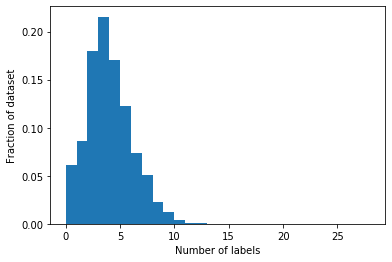

In [49]:
from matplotlib import pyplot as plt


def plot_label_frequency(L):
    plt.hist(
        (L != ABSTAIN).sum(axis=1),
        density=True,
        bins=range(L.shape[1])
    )
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

## Majority Label Voter Baseline

A simple baseline is helpful to evaluate the performance of the `LabelModel` we're about to train. We can use a majority vote labeler to label the data for comparison.

In [80]:
from snorkel.labeling import MajorityLabelVoter


majority_model = MajorityLabelVoter(cardinality=4)
preds_train = majority_model.predict(
    L=L_train,
)

## Generative LabelModel

Snorkel's generative `LabelModel` learns the relationships between labelers and creates a better label out of all of them.

In [78]:
from snorkel.labeling import LabelModel


label_model = LabelModel(cardinality=4, verbose=True)
label_model.fit(
    L_train=L_train,
    n_epochs=500,
    lr=0.001,
    log_freq=100,
    seed=31337
)

In [79]:
majority_acc = majority_model.score(L=L_test, Y=y_test, tie_break_policy='random')[
    'accuracy'
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_test, Y=y_test, tie_break_policy='random')[
    'accuracy'
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   74.3%
Label Model Accuracy:     73.3%


## Inspect Errors to Improve `LabelFunctions`

In [152]:
from snorkel.analysis import get_label_buckets


# Trim the fields for figuring out problems
df_viz = df_test[['full_name', 'description', 'readme']]

# Display all errors for debugging purposes
pd.set_option('display.max_rows', len(df_viz.index))


def get_mistakes(df, labels, names):
    """Take DataFrame and pair of actual/predicted labels/names and return a DataFrame showing those records."""
    df_fn = df.iloc[buckets[labels]]
    df_fn['probability'] = probs_test[buckets[labels], 1]
    df_fn['true label'] = names[0]
    df_fn['predicted label'] = names[1]
    return df_fn


def mistakes_df(df, label_model, L_test, y_test, names):
    """Compute a DataFrame of all the mistakes we've seen."""
    out_dfs = []
    
    probs_test = label_model.predict_proba(L=L_test)
    probs_test = probs_test >= 0.5
    
    buckets = get_label_buckets(y_test, probs_test[:, 1])
    
    for (actual, predicted) in buckets.keys():
        
        if actual != predicted:
            
            actual_name    = names[actual]
            predicted_name = names[predicted]

            out_dfs.append(
                get_mistakes(
                    df,
                    labels=(actual, predicted),
                    names=(actual_name, predicted_name)
                )
            )
    
    return out_dfs[0].append(
        out_dfs[1:]
    )


mistakes_df(df_viz, majority_model, L_test, y_test, names).head(202)

,full_name,description,readme,probability,true label,predicted label
id,,,,,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,The Alexa Skills Kit SDK for Node.js helps you...,"<p align=""center"">\n <img src=""https://m.medi...",False,API,GENERAL
38904647,alexa/alexa-skills-kit-sdk-for-java,The Alexa Skills Kit SDK for Java helps you ge...,"<p align=""center"">\n <img src=""https://m.medi...",False,API,GENERAL
130283857,alexa/alexa-skills-kit-sdk-for-python,The Alexa Skills Kit SDK for Python helps you ...,.. raw:: html\n\n <embed>\n <p align...,False,API,GENERAL
88652049,alexa/alexa-smarthome,Resources for Alexa Smart Home developers.,# Alexa Smart Home Resources\n\nThis repositor...,False,API,GENERAL
111734773,alexa/skill-sample-nodejs-test-automation,This sample skill demonstrates how to automate...,# Test Automation for Alexa Skills\n\n## **Rel...,False,API,GENERAL
145045841,alexa/alexa-apis-for-python,The Alexa APIs for Python consists of python c...,.. raw:: html\n\n <embed>\n <p align...,False,API,GENERAL
142473904,alexa/ask-toolkit-for-vscode,ASK Toolkit is an extension for Visual Studio ...,# Overview\n\nASK Toolkit for Visual Studio Co...,False,API,GENERAL
156932801,alexa/alexa-smart-screen-sdk,The Alexa Smart Screen SDK enables device make...,# Alexa Smart Screen SDK\n\nThe [Alexa Smart S...,False,API,GENERAL
145045923,alexa/alexa-apis-for-nodejs,The Alexa APIs for NodeJS consists of JS and T...,"<p align=""center"">\n <img src=""https://m.medi...",False,API,GENERAL


In [148]:
# Libraries we said are API but are really EDUCATION
mistake_dfs = []

mistake_dfs.append(
    get_mistakes(
        df_viz,
        labels=(EDUCATION, API),
        names=('EDUCATION', 'API')
    )
)

# Libraries we said are API but are really GENERAL
mistake_dfs.append(
    get_mistakes(
        df_viz,
        labels=(GENERAL, API),
        names=('GENERAL', 'API')
    )
)



mistake_dfs[0].append(mistake_dfs[1:])

,full_name,description,readme,probability,true label,predicted label
id,,,,,,
107600830,aws/aws-lambda-go,"Libraries, samples and tools to help Go develo...",# AWS Lambda for Go \n[![GoDoc][1]][2]\n[![Bui...,True,EDUCATION,API
159005377,aws/containers-roadmap,This is the public roadmap for AWS container s...,## Containers Roadmap\n\nThis is the public ro...,True,EDUCATION,API
151299222,amzn/smoke-framework,A light-weight server-side service framework w...,"<p align=""center"">\n<a href=""https://travis-ci...",True,GENERAL,API
143047851,amzn/MXFusion,Modular Probabilistic Programming on MXNet,# MXFusion\n[![Build Status](https://travis-ci...,True,GENERAL,API
98936297,amzn/oss-attribution-builder,The OSS Attribution Builder is a website that ...,# OSS Attribution Builder\n\nOSS Attribution B...,True,GENERAL,API
143745324,amzn/tiny-attribution-generator,A small tool and library to create attribution...,## Tiny Attribution Generator\n\nA small tool ...,True,GENERAL,API
171392350,amzn/service-model-swift-code-generate,Modular code generator to generate Swift appli...,"<p align=""center"">\n<a href=""https://travis-ci...",True,GENERAL,API
145019226,amzn/ion-hive-serde,A Apache Hive SerDe (short for serializer/dese...,## Amazon Ion Hive Serde\n\nA Apache Hive SerD...,True,GENERAL,API
121417140,amzn/ion-test-driver,A cross-implementation test driver for Amazon ...,Ion Test Driver\n============================\...,True,GENERAL,API
